In [19]:
#Importing the necessary modules, functions and classes
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns

In [2]:
#Reading the CV file into a data frame 
df = pd.read_csv(r"C:\Users\saeed\Downloads\train (6).csv")
#Taking a quick look at the dataframe and reviewing some summary metrics
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
#Removing the Cabin feature for having too many missing values
df.drop(["Cabin"], inplace = True, axis = 1)

In [25]:
#Dropping the Name and PassengerId columns since we don't want our model to overfit by learning patterns in those features
df.drop(["Name", "PassengerId"], inplace = True, axis = 1)

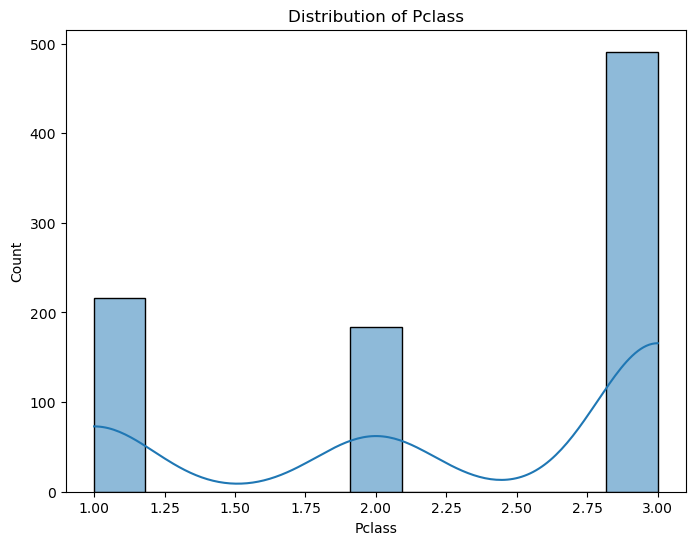

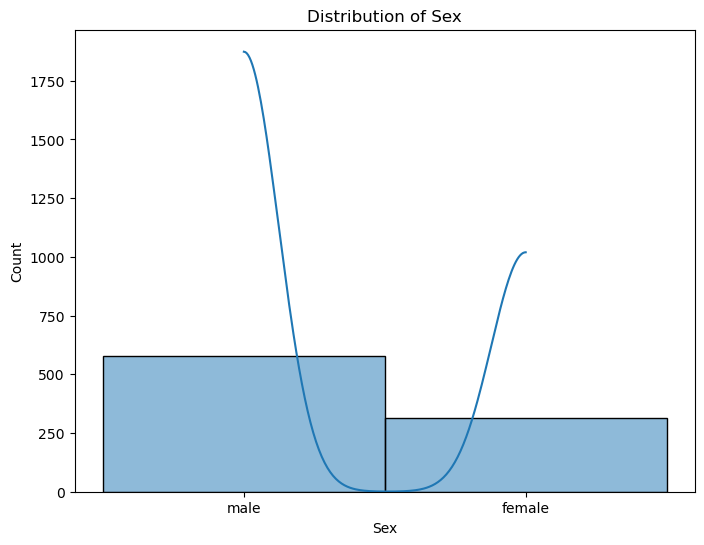

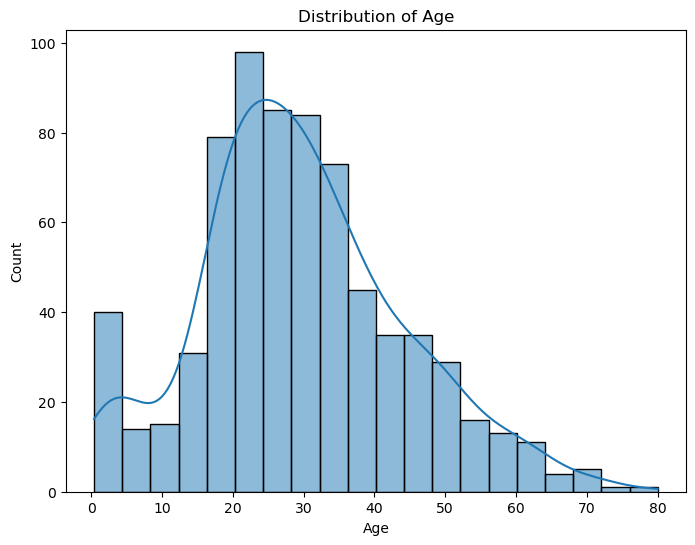

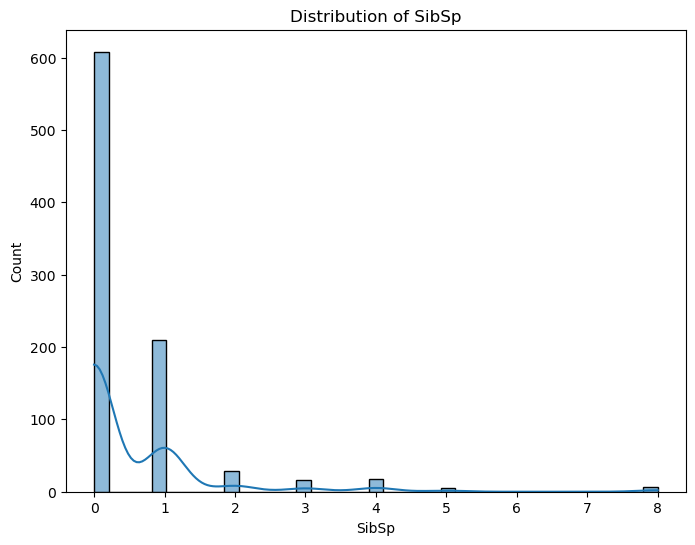

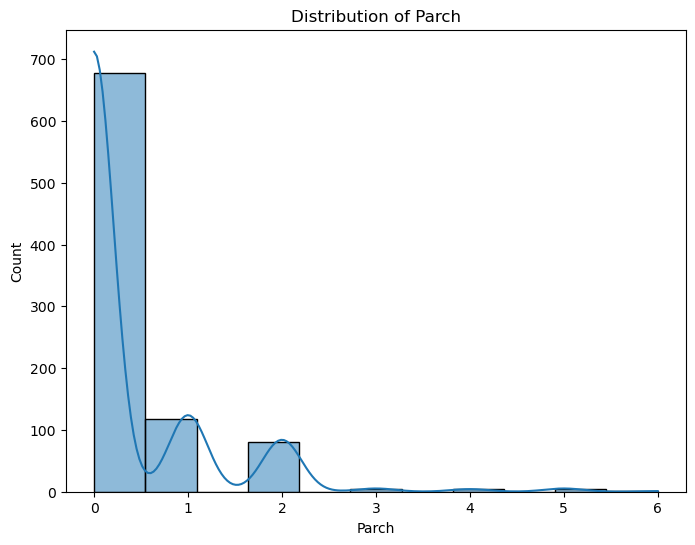

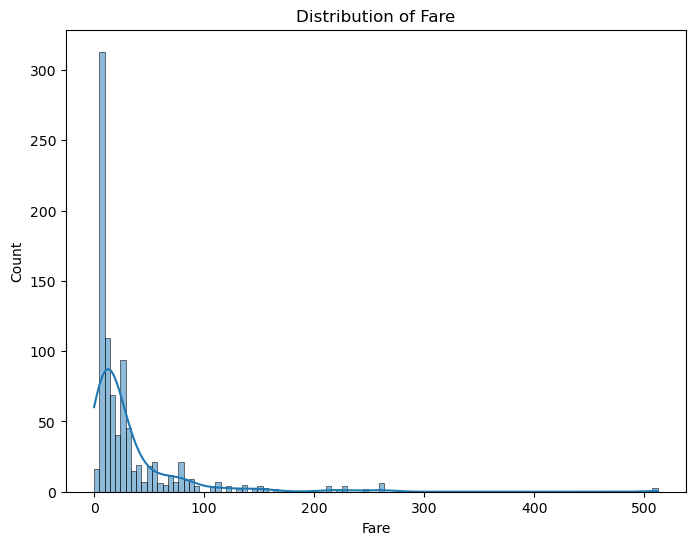

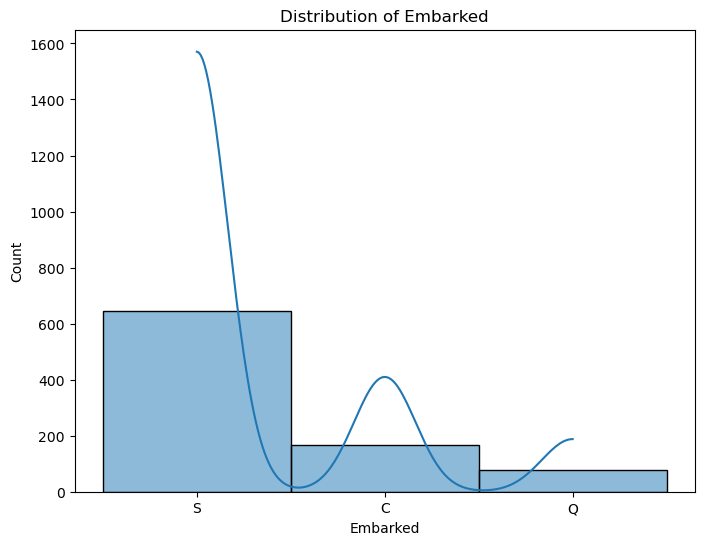

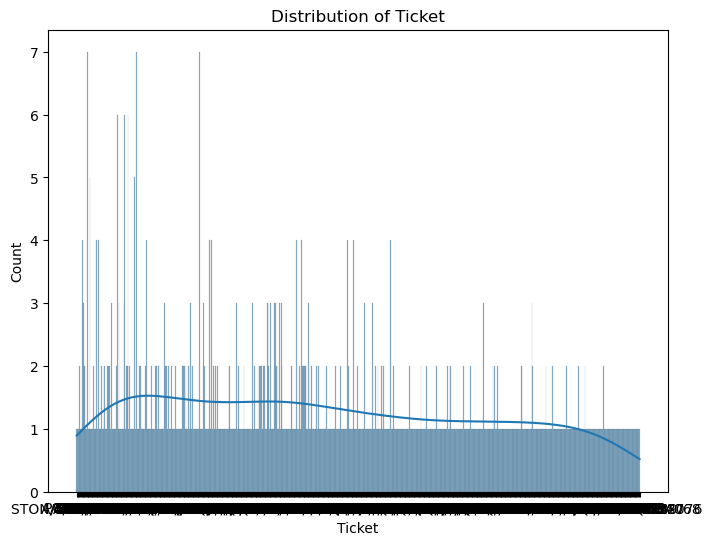

In [5]:
#Visaulizing the distribution of our features
# Defining the features to visualize
features_to_visualize = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Ticket']

# Loop through each feature and create a distribution plot
for feature in features_to_visualize:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


In [7]:
#The ticket feature seems to have too many categories, checking its value_counts
df['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [8]:
#It seems like the feature has too many categories and not enough instances in each category for the model to learn from
#We will drop this feature
df.drop('Ticket', axis = 1, inplace = True)

In [36]:
#Creating categorical and numerical features variables to store our caterogical and numerical features 
#SibSp and Parch represent the numer of siblings, parents or children the passenger had respectively, since they have concrete categories it would be wise to treat them as categorical data
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch',
       'Embarked']
numerical_features = ['Age', 'Fare']

In [37]:
#Creating Cross-tables to check the interactions between the categorical features and the target variable
for feature in categorical_features:
    cross_tab = pd.crosstab(df[feature], df['Survived'])
    print(f"Cross-tabulation for {feature}:\n{cross_tab}\n")


Cross-tabulation for Pclass:
Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

Cross-tabulation for Sex:
Survived    0    1
Sex               
female     81  233
male      468  109

Cross-tabulation for SibSp:
Survived    0    1
SibSp             
0         398  210
1          97  112
2          15   13
3          12    4
4          15    3
5           5    0
8           7    0

Cross-tabulation for Parch:
Survived    0    1
Parch             
0         445  233
1          53   65
2          40   40
3           2    3
4           4    0
5           4    1
6           1    0

Cross-tabulation for Embarked:
Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  217



In [38]:
#Building peprocessing pipelines
# Pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')

)
])

In [39]:
# Pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

In [40]:
# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [48]:
# Create the full pipeline
#Create pipeline for each model we are going to use seperately and then encapsulating them all in a dictionary to navigate throught them easily
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestClassifier())
])

pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('svm', SVC())
])

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)),
    ('logistic_regression', LogisticRegression())
])

# Create a dictionary of pipelines
pipelines = {
    'random_forest': pipeline_rf,
    'svm': pipeline_svm,
    'logistic_regression': pipeline_lr
}


In [49]:
# Split the data
X = df.drop("Survived", axis=1)
y = df["Survived"]

In [50]:
# Define parameter grids for each pipeline (assuming they have different hyperparameters)
param_grids = {
    'random_forest': {
        'random_forest__n_estimators': [50, 100, 200],  # Parameter for RandomForestClassifier
        'random_forest__max_depth': [None, 10, 20],  # Parameter for RandomForestClassifier
        'random_forest__min_samples_split': [2, 5, 10]  # Parameter for RandomForestClassifier
    },
    'svm': {
        'svm__C': [0.1, 1],  # Parameter for SVM
        'svm__kernel': ['linear', 'rbf'],  # Parameter for SVM
        'svm__gamma': ['scale', 'auto']  # Parameter for SVM
    },
    'logistic_regression': {
        'logistic_regression__C': [0.1, 1],  # Parameter for Logistic Regression
        'logistic_regression__solver': ['liblinear', 'lbfgs']  # Parameter for Logistic Regression
    }
}


In [51]:
# Create an empty dictionary to store the best models
best_models = {}

# Iterate over each pipeline and its corresponding parameter grid
for name, pipeline in pipelines.items():
    # Get the parameter grid for the current pipeline
    
    param_grid = param_grids[name]
    
    # Create a GridSearchCV instance for the current pipeline
    grid_search = GridSearchCV(pipeline, param_grid, cv=5)
    
    try:
        # Perform grid search
        grid_search.fit(X, y)
        
        # Get the best model from the grid search
        best_models[name] = grid_search.best_estimator_

        # Print or store the best parameters and scores for each pipeline
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best score for {name}: {grid_search.best_score_}")
    
    except Exception as e:
        # Handle the error
        print(f"Error occurred while performing grid search for {name}: {e}")


Best parameters for random_forest: {'random_forest__max_depth': 10, 'random_forest__min_samples_split': 5, 'random_forest__n_estimators': 200}
Best score for random_forest: 0.8227041616973197
Best parameters for svm: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best score for svm: 0.8091959073504487
Best parameters for logistic_regression: {'logistic_regression__C': 1, 'logistic_regression__solver': 'liblinear'}
Best score for logistic_regression: 0.8058376749733226
